# Imports

In [189]:
from __future__ import absolute_import, division, print_function
import pandas as pd
import cv2
from matplotlib import pyplot as plt
import os
import matplotlib
import numpy as np
import random
from numpy import linalg as LA
from PIL import Image
import sys
import itertools
import scipy.linalg as s_linalg
import math
from sklearn.model_selection import train_test_split  
from sklearn.svm import SVC 
from sklearn.metrics import classification_report, confusion_matrix ,accuracy_score
from skimage import color
from skimage.feature import hog
from sklearn import svm
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow import keras
import re
import warnings

In [190]:
warnings.filterwarnings('ignore')

# Data Preprocessing

## Function for reading dataset 

In [73]:
def read_dataset(directory,class_count,image_count):
    dataset = {}
    key = ''
    ext = ['.pgm','.jpeg','.jpg']
    cc = class_count+1
    for root, dirs, files in os.walk(directory):
        if not (root == directory):
            key = root.split('\\')[1]
            cc -= 1
            if cc <= 0:
                break
            dataset[key] = []
            c = image_count
        for name in files:
            filename, file_extension = os.path.splitext(name)
            if file_extension not in ext:
                continue
            cap = cv2.imread(directory+'/'+key+'/'+name, cv2.IMREAD_GRAYSCALE)
            dataset[key].append(cap)
            c -= 1
            if c <= 0:
                break
    print()
    return dataset

## Function to resize an image

In [3]:
def resize_images(dataset,image_height,image_width):
    for class_c in dataset:
        for i in range(len(dataset[class_c])):
            dataset[class_c][i] =  cv2.resize(dataset[class_c][i], (image_height,image_width))
    return dataset

## Function to create Testing and Training Set

In [4]:
def create_test_train_set(dataset,testSetSize,number_of_images_per_class):
    trainingSet = {}
    testingSet = {}
    for class_c in dataset:
        testSetIndex = []
        while len(testSetIndex) <= testSetSize:
            test_image_i = random.randint(1,number_of_images_per_class-1)
            if test_image_i in testSetIndex:
                continue
            testSetIndex.append(test_image_i)
        if class_c=='michael' or class_c =='stephen':
            print('Class :',class_c,'\t','TestSet Index :',testSetIndex)
        else:
            print('Class :',class_c,'\t\t','TestSet Index :',testSetIndex)
        index_image_i = 0
        trainingSet[class_c] = []
        testingSet[class_c] = []
        for image_i in dataset[class_c]:
            image_vecotr = []
            for heightDimension in image_i:
                for widthDimension in heightDimension:
                    image_vecotr.append(widthDimension)
            if index_image_i in testSetIndex:
                testingSet[class_c].append(image_vecotr[:])
            else:
                trainingSet[class_c].append(image_vecotr[:])
            index_image_i += 1
    print()
    return trainingSet,testingSet

## Fucntion to data zero-centered (Mean Substraction)

In [5]:
def mean_subtraction(trainingSet,trainSetSize):
    class_mean = pd.DataFrame()
    for class_c in trainingSet:
        print('Calculating mean for :',class_c)
        trainingSet[class_c] = pd.DataFrame(trainingSet[class_c])
        trainingSet[class_c] = trainingSet[class_c].T
        class_mean[class_c+'_'+'mean'] = trainingSet[class_c].sum(axis=1)/trainSetSize
    print()
    for class_c in trainingSet:
        print('Subtracting mean for :',class_c)
        for image_i in list(trainingSet[class_c]):
            trainingSet[class_c][image_i] = trainingSet[class_c][image_i] - class_mean[class_c+'_'+'mean']
    print()
    return trainingSet, class_mean

## Build testing set from all the individual classes

In [6]:
def build_testing_set(testingSet):
    completeTestSet = pd.DataFrame()
    for class_c in testingSet:
        testingSet[class_c] = pd.DataFrame(testingSet[class_c])
        testingSet[class_c] = testingSet[class_c].T
    for class_c in testingSet:
        for image_i in list(testingSet[class_c]):
            completeTestSet[class_c+'_'+str(image_i)] = testingSet[class_c][image_i]
    print()
    return completeTestSet

# Algorithms

## L1 PCA Single Bit Flip

In [7]:
def l1pca_SBF_rank1_simplified(dfX,L):
    N = len(dfX.T) #Number of data points
    max_iter = 1000 #Number of iteration    
    delta = [0] * N #array to store quadratic value
    obj_val = 0 #initialize the objective function's value ||X*b||_2^2
    
    for i in range(0,L): #loop through initializations
        b = np.random.choice([0, 1], size=(N,), p=[1./3, 2./3])* 2 - 1;
        dfb = pd.DataFrame(b)
        j = 0
        for j in range(0,max_iter): #loop of iterations for bit flipping
            for k in range(0,N): #loop over N bits in b
                dfbk = dfb.copy()
                dfXk = dfX.copy()
                dfbk = dfbk.drop([k])
                dfXk = dfXk.drop([k],axis=1)
                tmp = pd.DataFrame(dfX.loc[:,k])
                tmp = tmp.apply(lambda x: x*dfb.loc[k][0])
                tmp = tmp.T.dot(dfXk.dot(dfbk))
                delta[k] = -4 * list(tmp[list(tmp)[0]])[0] #calculate the "increase of the objective function" after flipping the i-th bit 
            ID = sorted(range(len(delta)), key=lambda g: delta[g],reverse = True) #sort delta and find the bit that leads to the highest increase
            val = np.sort(delta)[::-1]
            if val[0] > 0: #if the highest "increase" is positive
                b[ID[0]] = -b[ID[0]] #then flip the corresponding bit in b
            else:
                break #otherwise, SBF terminates
        tmp = LA.norm(dfX.dot(dfb)) #calculate the  objective function's value
        if tmp > obj_val: #if larger than the old obj function value
            obj_val = tmp
            bopt = b #then update the obj function value, and the optimal b
            l_best = i
    dfbopt = pd.DataFrame(bopt)
    Qprop = dfX.dot(dfbopt)/LA.norm(dfX.dot(dfbopt)) #PCA X*bopt/norm(X*bopt)
    Bprop = dfbopt
    return Qprop,Bprop,l_best,j

## Greedy Algorithm

In [8]:
def greedy_algorithm_find_k_principal_component(trainingSet,number_of_principal_component,number_of_initialization):
    QrL1 = pd.DataFrame()
    for principal_component_i in range(1,number_of_principal_component+1):
        print('Principal Component: ',principal_component_i)
        for class_c in trainingSet:
            Qprop,Bprop,l_best,iteration = l1pca_SBF_rank1_simplified(trainingSet[class_c],number_of_initialization)
            if class_c=='michael' or class_c =='stephen':
                print('Class :',class_c,'\t','Best Initialization :',l_best,'\t','Iteration :',iteration)
            else:
                print('Class :',class_c,'\t\t','Best Initialization :',l_best,'\t','Iteration :',iteration)
            QrL1[str(principal_component_i)+'_'+str(class_c)] = Qprop[0].values
        for class_c in trainingSet:
            trainingSet[class_c] = trainingSet[class_c] - QrL1[[str(principal_component_i)+'_'+str(class_c)]].dot(QrL1[[str(principal_component_i)+'_'+str(class_c)]].T.dot(trainingSet[class_c]))
    print()
    return QrL1

## Nearest Neighbor

In [9]:
def NearestNeighbor(testSet,class_mean,QrL1,number_of_principal_component,classes):
    accuracy = []
    d = {}
    for principal_component_i in range(1,number_of_principal_component+1):
        labels = []
        print('Principal_Component :',principal_component_i)
        for test_image_i in testSet:
            error = sys.maxsize
            min_error = sys.maxsize
            test_label = ''
            true_label = test_image_i.split('_')[0]
            for class_c in classes:
                number_of_components = []
                for component_i in range(1,principal_component_i+1):
                    number_of_components.append(str(component_i)+'_'+class_c)
                image_i = pd.DataFrame()
                image_i[0] = testSet[test_image_i].copy()
                error =  LA.norm((image_i[0] - class_mean[class_c+'_'+'mean']) - QrL1[number_of_components].dot(QrL1[number_of_components].T.dot((image_i[0] - class_mean[class_c+'_'+'mean']))))
                if error < min_error:
                    min_error = error
                    test_label = class_c
            image_label = []
            image_label.append(true_label)
            image_label.append(test_label)
            labels.append(image_label)
        accurate = 0
        for label in labels:
            if label[0] == label[1]:
                accurate += 1
        
        d[principal_component_i] = [accurate,len(testSet.T)]
        print('Accuracy :',round(((accurate/len(list(testSet)))*100),2),'\t','Error :',round((((len(list(testSet))-accurate)/len(list(testSet)))*100),2))
        print()
        
    
    return d

## Fucntion for face recognition

In [10]:
def face_recognition_l1_pca(dataset_name,number_of_classes,number_of_images_per_class,image_height,image_width,num_of_principal_component,num_of_initailization):
    dataset = read_dataset(dataset_name,number_of_classes,number_of_images_per_class)
    dataset = resize_images(dataset,image_height,image_width)
    number_of_class = len(dataset)
    number_of_images_per_class = len(dataset[list(dataset)[0]])
    print('Number of Classes :',number_of_class,'\t','Number of Images per Class :',number_of_images_per_class)
    print()
    number_of_train_images_per_class = math.ceil(number_of_images_per_class * 0.8)
    number_of_test_images_per_class = math.floor(number_of_images_per_class * 0.2)
    print('Number of train images per class :',number_of_train_images_per_class,'\t','Number of test images per class :',number_of_test_images_per_class)
    print()
    trainingSet,testingSet = create_test_train_set(dataset,number_of_test_images_per_class,number_of_images_per_class)
    trainingSet,class_mean = mean_subtraction(trainingSet,number_of_train_images_per_class)
    classes = list(trainingSet)
    testingSet = build_testing_set(testingSet)
    number_of_principal_component = num_of_principal_component
    number_of_initailization = num_of_initailization
    QrL1 = greedy_algorithm_find_k_principal_component(trainingSet,number_of_principal_component,number_of_initailization)
    d = NearestNeighbor(testingSet,class_mean,QrL1,number_of_principal_component,classes)
    return QrL1, trainingSet,testingSet, d

# Experimental Studies

# Aberdeen

In [41]:
number_of_experiments = 20
num_of_principal_component = 6
num_of_initailization = 10
image_height = 50
image_width = 50
dataset_name = 'Aberdeen'
number_of_classes = 8
number_of_images_per_class = 18
accuracy_list = {}
for expirement in range(number_of_experiments):
    print("Expirement :",expirement+1)
    QrL1, trainingSet,testingSet, d = face_recognition_l1_pca(dataset_name,number_of_classes,number_of_images_per_class,image_height,image_width,num_of_principal_component,num_of_initailization)
    accuracy_list[expirement+1] = d

Expirement : 1

Number of Classes : 8 	 Number of Images per Class : 18

Number of train images per class : 13 	 Number of test images per class : 5

Class : lisa 		 TestSet Index : [16, 10, 4, 6, 1, 17]
Class : louise 		 TestSet Index : [17, 2, 1, 15, 6, 5]
Class : marie 		 TestSet Index : [12, 10, 4, 15, 13, 6]
Class : michael 	 TestSet Index : [15, 9, 10, 11, 16, 14]
Class : nick 		 TestSet Index : [5, 12, 4, 2, 11, 8]
Class : pat 		 TestSet Index : [7, 16, 2, 1, 15, 5]
Class : stephen 	 TestSet Index : [1, 17, 11, 2, 14, 12]
Class : trevor 		 TestSet Index : [11, 6, 8, 15, 17, 4]

Calculating mean for : lisa
Calculating mean for : louise
Calculating mean for : marie
Calculating mean for : michael
Calculating mean for : nick
Calculating mean for : pat
Calculating mean for : stephen
Calculating mean for : trevor

Subtracting mean for : lisa
Subtracting mean for : louise
Subtracting mean for : marie
Subtracting mean for : michael
Subtracting mean for : nick
Subtracting mean for : pat


Accuracy : 100.0 	 Error : 0.0

Principal_Component : 2
Accuracy : 100.0 	 Error : 0.0

Principal_Component : 3
Accuracy : 100.0 	 Error : 0.0

Principal_Component : 4
Accuracy : 100.0 	 Error : 0.0

Principal_Component : 5
Accuracy : 100.0 	 Error : 0.0

Principal_Component : 6
Accuracy : 100.0 	 Error : 0.0

Expirement : 3

Number of Classes : 8 	 Number of Images per Class : 18

Number of train images per class : 13 	 Number of test images per class : 5

Class : lisa 		 TestSet Index : [7, 15, 2, 8, 9, 13]
Class : louise 		 TestSet Index : [4, 13, 10, 5, 12, 1]
Class : marie 		 TestSet Index : [10, 15, 9, 16, 5, 8]
Class : michael 	 TestSet Index : [8, 6, 13, 4, 11, 17]
Class : nick 		 TestSet Index : [6, 13, 14, 11, 15, 10]
Class : pat 		 TestSet Index : [15, 13, 10, 7, 9, 16]
Class : stephen 	 TestSet Index : [7, 15, 17, 11, 16, 12]
Class : trevor 		 TestSet Index : [14, 11, 4, 16, 10, 13]

Calculating mean for : lisa
Calculating mean for : louise
Calculating mean for : marie
Calc

Class : marie 		 Best Initialization : 1 	 Iteration : 5
Class : michael 	 Best Initialization : 1 	 Iteration : 3
Class : nick 		 Best Initialization : 3 	 Iteration : 4
Class : pat 		 Best Initialization : 0 	 Iteration : 7
Class : stephen 	 Best Initialization : 0 	 Iteration : 3
Class : trevor 		 Best Initialization : 1 	 Iteration : 6

Principal_Component : 1
Accuracy : 89.58 	 Error : 10.42

Principal_Component : 2
Accuracy : 91.67 	 Error : 8.33

Principal_Component : 3
Accuracy : 95.83 	 Error : 4.17

Principal_Component : 4
Accuracy : 100.0 	 Error : 0.0

Principal_Component : 5
Accuracy : 100.0 	 Error : 0.0

Principal_Component : 6
Accuracy : 100.0 	 Error : 0.0

Expirement : 5

Number of Classes : 8 	 Number of Images per Class : 18

Number of train images per class : 13 	 Number of test images per class : 5

Class : lisa 		 TestSet Index : [6, 11, 16, 5, 13, 17]
Class : louise 		 TestSet Index : [12, 5, 16, 4, 9, 6]
Class : marie 		 TestSet Index : [9, 5, 14, 12, 15, 11]
C

Class : nick 		 Best Initialization : 0 	 Iteration : 6
Class : pat 		 Best Initialization : 1 	 Iteration : 4
Class : stephen 	 Best Initialization : 0 	 Iteration : 5
Class : trevor 		 Best Initialization : 1 	 Iteration : 8
Principal Component:  6
Class : lisa 		 Best Initialization : 0 	 Iteration : 4
Class : louise 		 Best Initialization : 0 	 Iteration : 6
Class : marie 		 Best Initialization : 0 	 Iteration : 5
Class : michael 	 Best Initialization : 1 	 Iteration : 5
Class : nick 		 Best Initialization : 2 	 Iteration : 3
Class : pat 		 Best Initialization : 1 	 Iteration : 4
Class : stephen 	 Best Initialization : 0 	 Iteration : 4
Class : trevor 		 Best Initialization : 2 	 Iteration : 5

Principal_Component : 1
Accuracy : 89.58 	 Error : 10.42

Principal_Component : 2
Accuracy : 93.75 	 Error : 6.25

Principal_Component : 3
Accuracy : 95.83 	 Error : 4.17

Principal_Component : 4
Accuracy : 100.0 	 Error : 0.0

Principal_Component : 5
Accuracy : 100.0 	 Error : 0.0

Principa

Class : stephen 	 Best Initialization : 0 	 Iteration : 4
Class : trevor 		 Best Initialization : 1 	 Iteration : 4
Principal Component:  5
Class : lisa 		 Best Initialization : 0 	 Iteration : 4
Class : louise 		 Best Initialization : 0 	 Iteration : 2
Class : marie 		 Best Initialization : 0 	 Iteration : 5
Class : michael 	 Best Initialization : 0 	 Iteration : 5
Class : nick 		 Best Initialization : 1 	 Iteration : 4
Class : pat 		 Best Initialization : 1 	 Iteration : 5
Class : stephen 	 Best Initialization : 0 	 Iteration : 4
Class : trevor 		 Best Initialization : 0 	 Iteration : 4
Principal Component:  6
Class : lisa 		 Best Initialization : 0 	 Iteration : 5
Class : louise 		 Best Initialization : 0 	 Iteration : 5
Class : marie 		 Best Initialization : 0 	 Iteration : 4
Class : michael 	 Best Initialization : 0 	 Iteration : 3
Class : nick 		 Best Initialization : 0 	 Iteration : 4
Class : pat 		 Best Initialization : 0 	 Iteration : 5
Class : stephen 	 Best Initialization : 

Class : lisa 		 Best Initialization : 0 	 Iteration : 3
Class : louise 		 Best Initialization : 0 	 Iteration : 3
Class : marie 		 Best Initialization : 0 	 Iteration : 7
Class : michael 	 Best Initialization : 0 	 Iteration : 6
Class : nick 		 Best Initialization : 0 	 Iteration : 7
Class : pat 		 Best Initialization : 0 	 Iteration : 5
Class : stephen 	 Best Initialization : 2 	 Iteration : 6
Class : trevor 		 Best Initialization : 0 	 Iteration : 5
Principal Component:  5
Class : lisa 		 Best Initialization : 0 	 Iteration : 2
Class : louise 		 Best Initialization : 1 	 Iteration : 5
Class : marie 		 Best Initialization : 1 	 Iteration : 3
Class : michael 	 Best Initialization : 0 	 Iteration : 3
Class : nick 		 Best Initialization : 1 	 Iteration : 2
Class : pat 		 Best Initialization : 0 	 Iteration : 6
Class : stephen 	 Best Initialization : 2 	 Iteration : 2
Class : trevor 		 Best Initialization : 1 	 Iteration : 3
Principal Component:  6
Class : lisa 		 Best Initialization : 0 

Class : marie 		 Best Initialization : 0 	 Iteration : 5
Class : michael 	 Best Initialization : 0 	 Iteration : 6
Class : nick 		 Best Initialization : 0 	 Iteration : 5
Class : pat 		 Best Initialization : 0 	 Iteration : 6
Class : stephen 	 Best Initialization : 0 	 Iteration : 6
Class : trevor 		 Best Initialization : 0 	 Iteration : 5
Principal Component:  4
Class : lisa 		 Best Initialization : 1 	 Iteration : 5
Class : louise 		 Best Initialization : 0 	 Iteration : 3
Class : marie 		 Best Initialization : 0 	 Iteration : 5
Class : michael 	 Best Initialization : 2 	 Iteration : 4
Class : nick 		 Best Initialization : 0 	 Iteration : 7
Class : pat 		 Best Initialization : 0 	 Iteration : 5
Class : stephen 	 Best Initialization : 0 	 Iteration : 7
Class : trevor 		 Best Initialization : 0 	 Iteration : 4
Principal Component:  5
Class : lisa 		 Best Initialization : 1 	 Iteration : 7
Class : louise 		 Best Initialization : 0 	 Iteration : 3
Class : marie 		 Best Initialization : 0

Class : nick 		 Best Initialization : 0 	 Iteration : 6
Class : pat 		 Best Initialization : 0 	 Iteration : 4
Class : stephen 	 Best Initialization : 0 	 Iteration : 4
Class : trevor 		 Best Initialization : 0 	 Iteration : 5
Principal Component:  3
Class : lisa 		 Best Initialization : 0 	 Iteration : 5
Class : louise 		 Best Initialization : 0 	 Iteration : 1
Class : marie 		 Best Initialization : 0 	 Iteration : 4
Class : michael 	 Best Initialization : 0 	 Iteration : 5
Class : nick 		 Best Initialization : 0 	 Iteration : 3
Class : pat 		 Best Initialization : 0 	 Iteration : 2
Class : stephen 	 Best Initialization : 0 	 Iteration : 3
Class : trevor 		 Best Initialization : 0 	 Iteration : 3
Principal Component:  4
Class : lisa 		 Best Initialization : 0 	 Iteration : 6
Class : louise 		 Best Initialization : 0 	 Iteration : 4
Class : marie 		 Best Initialization : 0 	 Iteration : 5
Class : michael 	 Best Initialization : 2 	 Iteration : 5
Class : nick 		 Best Initialization : 0 

Class : stephen 	 Best Initialization : 0 	 Iteration : 2
Class : trevor 		 Best Initialization : 0 	 Iteration : 2
Principal Component:  2
Class : lisa 		 Best Initialization : 0 	 Iteration : 7
Class : louise 		 Best Initialization : 4 	 Iteration : 3
Class : marie 		 Best Initialization : 0 	 Iteration : 5
Class : michael 	 Best Initialization : 0 	 Iteration : 6
Class : nick 		 Best Initialization : 0 	 Iteration : 6
Class : pat 		 Best Initialization : 0 	 Iteration : 4
Class : stephen 	 Best Initialization : 0 	 Iteration : 5
Class : trevor 		 Best Initialization : 3 	 Iteration : 2
Principal Component:  3
Class : lisa 		 Best Initialization : 0 	 Iteration : 4
Class : louise 		 Best Initialization : 0 	 Iteration : 4
Class : marie 		 Best Initialization : 0 	 Iteration : 7
Class : michael 	 Best Initialization : 0 	 Iteration : 3
Class : nick 		 Best Initialization : 0 	 Iteration : 4
Class : pat 		 Best Initialization : 0 	 Iteration : 4
Class : stephen 	 Best Initialization : 


Principal Component:  1
Class : lisa 		 Best Initialization : 0 	 Iteration : 5
Class : louise 		 Best Initialization : 0 	 Iteration : 4
Class : marie 		 Best Initialization : 0 	 Iteration : 4
Class : michael 	 Best Initialization : 0 	 Iteration : 5
Class : nick 		 Best Initialization : 0 	 Iteration : 3
Class : pat 		 Best Initialization : 0 	 Iteration : 6
Class : stephen 	 Best Initialization : 0 	 Iteration : 2
Class : trevor 		 Best Initialization : 0 	 Iteration : 5
Principal Component:  2
Class : lisa 		 Best Initialization : 0 	 Iteration : 3
Class : louise 		 Best Initialization : 0 	 Iteration : 6
Class : marie 		 Best Initialization : 2 	 Iteration : 5
Class : michael 	 Best Initialization : 0 	 Iteration : 6
Class : nick 		 Best Initialization : 0 	 Iteration : 5
Class : pat 		 Best Initialization : 0 	 Iteration : 5
Class : stephen 	 Best Initialization : 0 	 Iteration : 6
Class : trevor 		 Best Initialization : 0 	 Iteration : 5
Principal Component:  3
Class : lisa 		

Calculating mean for : nick
Calculating mean for : pat
Calculating mean for : stephen
Calculating mean for : trevor

Subtracting mean for : lisa
Subtracting mean for : louise
Subtracting mean for : marie
Subtracting mean for : michael
Subtracting mean for : nick
Subtracting mean for : pat
Subtracting mean for : stephen
Subtracting mean for : trevor


Principal Component:  1
Class : lisa 		 Best Initialization : 0 	 Iteration : 5
Class : louise 		 Best Initialization : 0 	 Iteration : 5
Class : marie 		 Best Initialization : 2 	 Iteration : 7
Class : michael 	 Best Initialization : 0 	 Iteration : 6
Class : nick 		 Best Initialization : 0 	 Iteration : 3
Class : pat 		 Best Initialization : 1 	 Iteration : 4
Class : stephen 	 Best Initialization : 0 	 Iteration : 5
Class : trevor 		 Best Initialization : 0 	 Iteration : 4
Principal Component:  2
Class : lisa 		 Best Initialization : 0 	 Iteration : 5
Class : louise 		 Best Initialization : 0 	 Iteration : 5
Class : marie 		 Best Initial

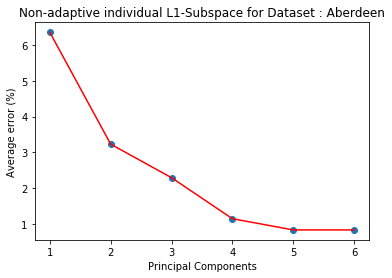

In [42]:
o = {}
for i in range(len(accuracy_list[1])):
    o[i+1] = [0,0]
for i in accuracy_list:
    for j in accuracy_list[i]:
        o[j] = [o[j][0]+accuracy_list[i][j][0],o[j][1]+accuracy_list[i][j][1]]
x = []
y = []
for i in range(1,len(o.keys())+1):
    x.append(i)
    y.append(((o[i][1]-o[i][0])*100)/o[i][1])
plt.plot(x,y,'o')
plt.plot(x,y,'red')
plt.xlabel('Principal Components')
plt.ylabel('Average error (%)')
plt.title('Non-adaptive individual L1-Subspace for Dataset : '+dataset_name)
plt.savefig('Error_rate_graph_for_Dataset_'+dataset_name+'.png')
plt.show()

In [43]:
print(o)

{1: [899, 960], 2: [929, 960], 3: [938, 960], 4: [949, 960], 5: [952, 960], 6: [952, 960]}


## Yale Extended B

In [44]:
number_of_experiments = 20
num_of_principal_component = 6
num_of_initailization = 10
image_height = 50
image_width = 50
dataset_name = 'CroppedYale'
number_of_classes = 8
number_of_images_per_class = 18
accuracy_list = {}
for expirement in range(number_of_experiments):
    print("Expirement :",expirement+1)
    QrL1, trainingSet,testingSet, d = face_recognition_l1_pca(dataset_name,number_of_classes,number_of_images_per_class,image_height,image_width,num_of_principal_component,num_of_initailization)
    accuracy_list[expirement+1] = d

Expirement : 1

Number of Classes : 8 	 Number of Images per Class : 18

Number of train images per class : 13 	 Number of test images per class : 5

Class : yaleB01 		 TestSet Index : [5, 14, 11, 3, 8, 16]
Class : yaleB02 		 TestSet Index : [3, 12, 6, 9, 7, 10]
Class : yaleB03 		 TestSet Index : [5, 14, 17, 6, 1, 4]
Class : yaleB04 		 TestSet Index : [4, 5, 16, 6, 13, 2]
Class : yaleB05 		 TestSet Index : [16, 11, 12, 9, 15, 2]
Class : yaleB06 		 TestSet Index : [7, 17, 4, 16, 6, 5]
Class : yaleB07 		 TestSet Index : [2, 16, 12, 15, 8, 14]
Class : yaleB08 		 TestSet Index : [4, 1, 14, 17, 5, 9]

Calculating mean for : yaleB01
Calculating mean for : yaleB02
Calculating mean for : yaleB03
Calculating mean for : yaleB04
Calculating mean for : yaleB05
Calculating mean for : yaleB06
Calculating mean for : yaleB07
Calculating mean for : yaleB08

Subtracting mean for : yaleB01
Subtracting mean for : yaleB02
Subtracting mean for : yaleB03
Subtracting mean for : yaleB04
Subtracting mean for : 

Class : yaleB04 		 Best Initialization : 0 	 Iteration : 6
Class : yaleB05 		 Best Initialization : 0 	 Iteration : 3
Class : yaleB06 		 Best Initialization : 0 	 Iteration : 4
Class : yaleB07 		 Best Initialization : 0 	 Iteration : 3
Class : yaleB08 		 Best Initialization : 6 	 Iteration : 6

Principal_Component : 1
Accuracy : 75.0 	 Error : 25.0

Principal_Component : 2
Accuracy : 85.42 	 Error : 14.58

Principal_Component : 3
Accuracy : 93.75 	 Error : 6.25

Principal_Component : 4
Accuracy : 93.75 	 Error : 6.25

Principal_Component : 5
Accuracy : 93.75 	 Error : 6.25

Principal_Component : 6
Accuracy : 93.75 	 Error : 6.25

Expirement : 3

Number of Classes : 8 	 Number of Images per Class : 18

Number of train images per class : 13 	 Number of test images per class : 5

Class : yaleB01 		 TestSet Index : [17, 14, 2, 10, 7, 1]
Class : yaleB02 		 TestSet Index : [9, 8, 6, 10, 5, 1]
Class : yaleB03 		 TestSet Index : [12, 9, 11, 3, 7, 4]
Class : yaleB04 		 TestSet Index : [5, 9, 1,

Class : yaleB02 		 Best Initialization : 0 	 Iteration : 4
Class : yaleB03 		 Best Initialization : 1 	 Iteration : 7
Class : yaleB04 		 Best Initialization : 0 	 Iteration : 4
Class : yaleB05 		 Best Initialization : 0 	 Iteration : 5
Class : yaleB06 		 Best Initialization : 0 	 Iteration : 5
Class : yaleB07 		 Best Initialization : 0 	 Iteration : 8
Class : yaleB08 		 Best Initialization : 0 	 Iteration : 6
Principal Component:  6
Class : yaleB01 		 Best Initialization : 0 	 Iteration : 6
Class : yaleB02 		 Best Initialization : 0 	 Iteration : 5
Class : yaleB03 		 Best Initialization : 0 	 Iteration : 3
Class : yaleB04 		 Best Initialization : 0 	 Iteration : 5
Class : yaleB05 		 Best Initialization : 0 	 Iteration : 5
Class : yaleB06 		 Best Initialization : 0 	 Iteration : 3
Class : yaleB07 		 Best Initialization : 0 	 Iteration : 5
Class : yaleB08 		 Best Initialization : 0 	 Iteration : 3

Principal_Component : 1
Accuracy : 70.83 	 Error : 29.17

Principal_Component : 2
Accuracy

Class : yaleB08 		 Best Initialization : 0 	 Iteration : 4
Principal Component:  4
Class : yaleB01 		 Best Initialization : 0 	 Iteration : 5
Class : yaleB02 		 Best Initialization : 0 	 Iteration : 6
Class : yaleB03 		 Best Initialization : 0 	 Iteration : 3
Class : yaleB04 		 Best Initialization : 0 	 Iteration : 5
Class : yaleB05 		 Best Initialization : 0 	 Iteration : 3
Class : yaleB06 		 Best Initialization : 0 	 Iteration : 3
Class : yaleB07 		 Best Initialization : 3 	 Iteration : 5
Class : yaleB08 		 Best Initialization : 0 	 Iteration : 7
Principal Component:  5
Class : yaleB01 		 Best Initialization : 0 	 Iteration : 6
Class : yaleB02 		 Best Initialization : 0 	 Iteration : 5
Class : yaleB03 		 Best Initialization : 0 	 Iteration : 6
Class : yaleB04 		 Best Initialization : 0 	 Iteration : 3
Class : yaleB05 		 Best Initialization : 0 	 Iteration : 6
Class : yaleB06 		 Best Initialization : 0 	 Iteration : 5
Class : yaleB07 		 Best Initialization : 1 	 Iteration : 5
Class : 

Class : yaleB06 		 Best Initialization : 1 	 Iteration : 3
Class : yaleB07 		 Best Initialization : 0 	 Iteration : 4
Class : yaleB08 		 Best Initialization : 0 	 Iteration : 4
Principal Component:  3
Class : yaleB01 		 Best Initialization : 0 	 Iteration : 5
Class : yaleB02 		 Best Initialization : 0 	 Iteration : 7
Class : yaleB03 		 Best Initialization : 0 	 Iteration : 5
Class : yaleB04 		 Best Initialization : 0 	 Iteration : 5
Class : yaleB05 		 Best Initialization : 0 	 Iteration : 5
Class : yaleB06 		 Best Initialization : 0 	 Iteration : 6
Class : yaleB07 		 Best Initialization : 0 	 Iteration : 7
Class : yaleB08 		 Best Initialization : 0 	 Iteration : 4
Principal Component:  4
Class : yaleB01 		 Best Initialization : 2 	 Iteration : 7
Class : yaleB02 		 Best Initialization : 0 	 Iteration : 6
Class : yaleB03 		 Best Initialization : 0 	 Iteration : 8
Class : yaleB04 		 Best Initialization : 0 	 Iteration : 4
Class : yaleB05 		 Best Initialization : 0 	 Iteration : 6
Class : 

Class : yaleB04 		 Best Initialization : 0 	 Iteration : 2
Class : yaleB05 		 Best Initialization : 0 	 Iteration : 4
Class : yaleB06 		 Best Initialization : 0 	 Iteration : 3
Class : yaleB07 		 Best Initialization : 0 	 Iteration : 3
Class : yaleB08 		 Best Initialization : 0 	 Iteration : 2
Principal Component:  2
Class : yaleB01 		 Best Initialization : 0 	 Iteration : 6
Class : yaleB02 		 Best Initialization : 0 	 Iteration : 6
Class : yaleB03 		 Best Initialization : 0 	 Iteration : 5
Class : yaleB04 		 Best Initialization : 0 	 Iteration : 6
Class : yaleB05 		 Best Initialization : 0 	 Iteration : 3
Class : yaleB06 		 Best Initialization : 0 	 Iteration : 4
Class : yaleB07 		 Best Initialization : 0 	 Iteration : 5
Class : yaleB08 		 Best Initialization : 0 	 Iteration : 3
Principal Component:  3
Class : yaleB01 		 Best Initialization : 0 	 Iteration : 5
Class : yaleB02 		 Best Initialization : 0 	 Iteration : 4
Class : yaleB03 		 Best Initialization : 0 	 Iteration : 7
Class : 

Calculating mean for : yaleB03
Calculating mean for : yaleB04
Calculating mean for : yaleB05
Calculating mean for : yaleB06
Calculating mean for : yaleB07
Calculating mean for : yaleB08

Subtracting mean for : yaleB01
Subtracting mean for : yaleB02
Subtracting mean for : yaleB03
Subtracting mean for : yaleB04
Subtracting mean for : yaleB05
Subtracting mean for : yaleB06
Subtracting mean for : yaleB07
Subtracting mean for : yaleB08


Principal Component:  1
Class : yaleB01 		 Best Initialization : 0 	 Iteration : 6
Class : yaleB02 		 Best Initialization : 0 	 Iteration : 5
Class : yaleB03 		 Best Initialization : 0 	 Iteration : 6
Class : yaleB04 		 Best Initialization : 0 	 Iteration : 5
Class : yaleB05 		 Best Initialization : 0 	 Iteration : 5
Class : yaleB06 		 Best Initialization : 0 	 Iteration : 6
Class : yaleB07 		 Best Initialization : 0 	 Iteration : 5
Class : yaleB08 		 Best Initialization : 0 	 Iteration : 3
Principal Component:  2
Class : yaleB01 		 Best Initialization : 0 

Class : yaleB08 		 TestSet Index : [14, 16, 11, 2, 10, 6]

Calculating mean for : yaleB01
Calculating mean for : yaleB02
Calculating mean for : yaleB03
Calculating mean for : yaleB04
Calculating mean for : yaleB05
Calculating mean for : yaleB06
Calculating mean for : yaleB07
Calculating mean for : yaleB08

Subtracting mean for : yaleB01
Subtracting mean for : yaleB02
Subtracting mean for : yaleB03
Subtracting mean for : yaleB04
Subtracting mean for : yaleB05
Subtracting mean for : yaleB06
Subtracting mean for : yaleB07
Subtracting mean for : yaleB08


Principal Component:  1
Class : yaleB01 		 Best Initialization : 2 	 Iteration : 3
Class : yaleB02 		 Best Initialization : 0 	 Iteration : 5
Class : yaleB03 		 Best Initialization : 0 	 Iteration : 6
Class : yaleB04 		 Best Initialization : 0 	 Iteration : 5
Class : yaleB05 		 Best Initialization : 0 	 Iteration : 1
Class : yaleB06 		 Best Initialization : 0 	 Iteration : 4
Class : yaleB07 		 Best Initialization : 0 	 Iteration : 2
Class

Accuracy : 91.67 	 Error : 8.33

Principal_Component : 6
Accuracy : 91.67 	 Error : 8.33

Expirement : 16

Number of Classes : 8 	 Number of Images per Class : 18

Number of train images per class : 13 	 Number of test images per class : 5

Class : yaleB01 		 TestSet Index : [11, 5, 13, 2, 16, 8]
Class : yaleB02 		 TestSet Index : [2, 6, 3, 16, 1, 8]
Class : yaleB03 		 TestSet Index : [7, 16, 5, 10, 2, 4]
Class : yaleB04 		 TestSet Index : [11, 6, 7, 3, 13, 16]
Class : yaleB05 		 TestSet Index : [12, 6, 17, 8, 13, 9]
Class : yaleB06 		 TestSet Index : [2, 1, 10, 15, 4, 16]
Class : yaleB07 		 TestSet Index : [15, 17, 5, 12, 16, 11]
Class : yaleB08 		 TestSet Index : [1, 13, 9, 5, 4, 11]

Calculating mean for : yaleB01
Calculating mean for : yaleB02
Calculating mean for : yaleB03
Calculating mean for : yaleB04
Calculating mean for : yaleB05
Calculating mean for : yaleB06
Calculating mean for : yaleB07
Calculating mean for : yaleB08

Subtracting mean for : yaleB01
Subtracting mean for : y

Class : yaleB03 		 Best Initialization : 1 	 Iteration : 2
Class : yaleB04 		 Best Initialization : 0 	 Iteration : 3
Class : yaleB05 		 Best Initialization : 0 	 Iteration : 3
Class : yaleB06 		 Best Initialization : 5 	 Iteration : 4
Class : yaleB07 		 Best Initialization : 0 	 Iteration : 5
Class : yaleB08 		 Best Initialization : 0 	 Iteration : 6

Principal_Component : 1
Accuracy : 70.83 	 Error : 29.17

Principal_Component : 2
Accuracy : 87.5 	 Error : 12.5

Principal_Component : 3
Accuracy : 93.75 	 Error : 6.25

Principal_Component : 4
Accuracy : 93.75 	 Error : 6.25

Principal_Component : 5
Accuracy : 93.75 	 Error : 6.25

Principal_Component : 6
Accuracy : 93.75 	 Error : 6.25

Expirement : 18

Number of Classes : 8 	 Number of Images per Class : 18

Number of train images per class : 13 	 Number of test images per class : 5

Class : yaleB01 		 TestSet Index : [14, 6, 13, 5, 16, 11]
Class : yaleB02 		 TestSet Index : [5, 12, 1, 4, 14, 2]
Class : yaleB03 		 TestSet Index : [4,

Class : yaleB01 		 Best Initialization : 1 	 Iteration : 3
Class : yaleB02 		 Best Initialization : 1 	 Iteration : 5
Class : yaleB03 		 Best Initialization : 0 	 Iteration : 6
Class : yaleB04 		 Best Initialization : 4 	 Iteration : 4
Class : yaleB05 		 Best Initialization : 1 	 Iteration : 4
Class : yaleB06 		 Best Initialization : 0 	 Iteration : 4
Class : yaleB07 		 Best Initialization : 0 	 Iteration : 5
Class : yaleB08 		 Best Initialization : 0 	 Iteration : 2
Principal Component:  6
Class : yaleB01 		 Best Initialization : 0 	 Iteration : 5
Class : yaleB02 		 Best Initialization : 0 	 Iteration : 5
Class : yaleB03 		 Best Initialization : 2 	 Iteration : 4
Class : yaleB04 		 Best Initialization : 0 	 Iteration : 5
Class : yaleB05 		 Best Initialization : 1 	 Iteration : 3
Class : yaleB06 		 Best Initialization : 0 	 Iteration : 8
Class : yaleB07 		 Best Initialization : 0 	 Iteration : 4
Class : yaleB08 		 Best Initialization : 0 	 Iteration : 5

Principal_Component : 1
Accurac

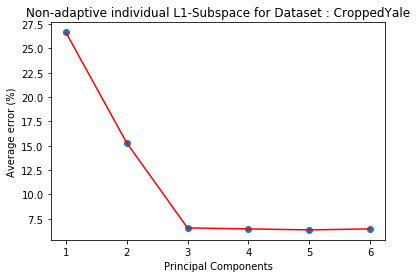

In [45]:
o = {}
for i in range(len(accuracy_list[1])):
    o[i+1] = [0,0]
for i in accuracy_list:
    for j in accuracy_list[i]:
        o[j] = [o[j][0]+accuracy_list[i][j][0],o[j][1]+accuracy_list[i][j][1]]
x = []
y = []
for i in range(1,len(o.keys())+1):
    x.append(i)
    y.append(((o[i][1]-o[i][0])*100)/o[i][1])
plt.plot(x,y,'o')
plt.plot(x,y,'red')
plt.xlabel('Principal Components')
plt.ylabel('Average error (%)')
plt.title('Non-adaptive individual L1-Subspace for Dataset : '+dataset_name)
plt.savefig('Error_rate_graph_for_Dataset_'+dataset_name+'.png')
plt.show()

In [46]:
print(o)

{1: [704, 960], 2: [813, 960], 3: [897, 960], 4: [898, 960], 5: [899, 960], 6: [898, 960]}


## ORL Dataset

In [183]:
number_of_experiments = 20
num_of_principal_component = 6
num_of_initailization = 10
image_height = 50
image_width = 50
dataset_name = 'ORLDatabase'
number_of_classes = 18
number_of_images_per_class = 18
accuracy_list = {}
for expirement in range(number_of_experiments):
    print("Expirement :",expirement+1)
    QrL1, trainingSet,testingSet, d = face_recognition_l1_pca(dataset_name,number_of_classes,number_of_images_per_class,image_height,image_width,num_of_principal_component,num_of_initailization)
    accuracy_list[expirement+1] = d

Expirement : 1

Number of Classes : 18 	 Number of Images per Class : 10

Number of train images per class : 8 	 Number of test images per class : 2

Class : s1 		 TestSet Index : [6, 1, 9]
Class : s10 		 TestSet Index : [6, 4, 1]
Class : s11 		 TestSet Index : [1, 6, 4]
Class : s12 		 TestSet Index : [2, 5, 7]
Class : s13 		 TestSet Index : [9, 8, 3]
Class : s14 		 TestSet Index : [2, 4, 6]
Class : s15 		 TestSet Index : [9, 1, 2]
Class : s16 		 TestSet Index : [5, 8, 9]
Class : s17 		 TestSet Index : [8, 3, 1]
Class : s18 		 TestSet Index : [6, 9, 4]
Class : s19 		 TestSet Index : [4, 8, 7]
Class : s2 		 TestSet Index : [9, 7, 5]
Class : s20 		 TestSet Index : [9, 5, 2]
Class : s21 		 TestSet Index : [6, 4, 9]
Class : s22 		 TestSet Index : [5, 8, 1]
Class : s23 		 TestSet Index : [4, 2, 5]
Class : s24 		 TestSet Index : [4, 6, 3]
Class : s25 		 TestSet Index : [1, 7, 5]

Calculating mean for : s1
Calculating mean for : s10
Calculating mean for : s11
Calculating mean for : s12
Calcul

Accuracy : 96.3 	 Error : 3.7

Expirement : 2

Number of Classes : 18 	 Number of Images per Class : 10

Number of train images per class : 8 	 Number of test images per class : 2

Class : s1 		 TestSet Index : [4, 3, 5]
Class : s10 		 TestSet Index : [2, 5, 6]
Class : s11 		 TestSet Index : [5, 1, 7]
Class : s12 		 TestSet Index : [9, 6, 7]
Class : s13 		 TestSet Index : [2, 5, 6]
Class : s14 		 TestSet Index : [6, 7, 4]
Class : s15 		 TestSet Index : [7, 3, 9]
Class : s16 		 TestSet Index : [9, 8, 7]
Class : s17 		 TestSet Index : [3, 6, 2]
Class : s18 		 TestSet Index : [1, 2, 8]
Class : s19 		 TestSet Index : [5, 6, 2]
Class : s2 		 TestSet Index : [7, 9, 5]
Class : s20 		 TestSet Index : [6, 7, 2]
Class : s21 		 TestSet Index : [9, 7, 3]
Class : s22 		 TestSet Index : [7, 8, 6]
Class : s23 		 TestSet Index : [4, 1, 2]
Class : s24 		 TestSet Index : [6, 5, 9]
Class : s25 		 TestSet Index : [2, 8, 7]

Calculating mean for : s1
Calculating mean for : s10
Calculating mean for : s11
Ca

Accuracy : 94.44 	 Error : 5.56

Principal_Component : 6
Accuracy : 94.44 	 Error : 5.56

Expirement : 3

Number of Classes : 18 	 Number of Images per Class : 10

Number of train images per class : 8 	 Number of test images per class : 2

Class : s1 		 TestSet Index : [5, 3, 7]
Class : s10 		 TestSet Index : [7, 8, 1]
Class : s11 		 TestSet Index : [2, 3, 6]
Class : s12 		 TestSet Index : [6, 4, 2]
Class : s13 		 TestSet Index : [5, 8, 4]
Class : s14 		 TestSet Index : [1, 3, 9]
Class : s15 		 TestSet Index : [8, 3, 1]
Class : s16 		 TestSet Index : [7, 2, 3]
Class : s17 		 TestSet Index : [1, 2, 7]
Class : s18 		 TestSet Index : [3, 6, 4]
Class : s19 		 TestSet Index : [5, 3, 1]
Class : s2 		 TestSet Index : [3, 2, 4]
Class : s20 		 TestSet Index : [4, 8, 2]
Class : s21 		 TestSet Index : [1, 8, 5]
Class : s22 		 TestSet Index : [8, 5, 6]
Class : s23 		 TestSet Index : [6, 5, 7]
Class : s24 		 TestSet Index : [1, 8, 5]
Class : s25 		 TestSet Index : [6, 2, 3]

Calculating mean for : 

Accuracy : 96.3 	 Error : 3.7

Principal_Component : 5
Accuracy : 96.3 	 Error : 3.7

Principal_Component : 6
Accuracy : 96.3 	 Error : 3.7

Expirement : 4

Number of Classes : 18 	 Number of Images per Class : 10

Number of train images per class : 8 	 Number of test images per class : 2

Class : s1 		 TestSet Index : [3, 9, 5]
Class : s10 		 TestSet Index : [7, 9, 4]
Class : s11 		 TestSet Index : [4, 7, 9]
Class : s12 		 TestSet Index : [8, 6, 3]
Class : s13 		 TestSet Index : [7, 1, 2]
Class : s14 		 TestSet Index : [6, 2, 5]
Class : s15 		 TestSet Index : [8, 9, 6]
Class : s16 		 TestSet Index : [7, 3, 6]
Class : s17 		 TestSet Index : [6, 7, 2]
Class : s18 		 TestSet Index : [2, 3, 4]
Class : s19 		 TestSet Index : [7, 3, 8]
Class : s2 		 TestSet Index : [6, 2, 9]
Class : s20 		 TestSet Index : [7, 8, 1]
Class : s21 		 TestSet Index : [8, 3, 7]
Class : s22 		 TestSet Index : [1, 8, 3]
Class : s23 		 TestSet Index : [4, 5, 8]
Class : s24 		 TestSet Index : [6, 5, 1]
Class : s25 		

Accuracy : 100.0 	 Error : 0.0

Principal_Component : 4
Accuracy : 100.0 	 Error : 0.0

Principal_Component : 5
Accuracy : 98.15 	 Error : 1.85

Principal_Component : 6
Accuracy : 98.15 	 Error : 1.85

Expirement : 5

Number of Classes : 18 	 Number of Images per Class : 10

Number of train images per class : 8 	 Number of test images per class : 2

Class : s1 		 TestSet Index : [4, 3, 6]
Class : s10 		 TestSet Index : [8, 3, 9]
Class : s11 		 TestSet Index : [3, 9, 5]
Class : s12 		 TestSet Index : [1, 8, 7]
Class : s13 		 TestSet Index : [4, 3, 1]
Class : s14 		 TestSet Index : [5, 8, 7]
Class : s15 		 TestSet Index : [6, 1, 9]
Class : s16 		 TestSet Index : [7, 3, 4]
Class : s17 		 TestSet Index : [2, 4, 1]
Class : s18 		 TestSet Index : [9, 5, 8]
Class : s19 		 TestSet Index : [6, 9, 7]
Class : s2 		 TestSet Index : [5, 3, 4]
Class : s20 		 TestSet Index : [2, 9, 6]
Class : s21 		 TestSet Index : [9, 8, 6]
Class : s22 		 TestSet Index : [6, 3, 5]
Class : s23 		 TestSet Index : [7, 

Accuracy : 98.15 	 Error : 1.85

Principal_Component : 3
Accuracy : 100.0 	 Error : 0.0

Principal_Component : 4
Accuracy : 100.0 	 Error : 0.0

Principal_Component : 5
Accuracy : 98.15 	 Error : 1.85

Principal_Component : 6
Accuracy : 100.0 	 Error : 0.0

Expirement : 6

Number of Classes : 18 	 Number of Images per Class : 10

Number of train images per class : 8 	 Number of test images per class : 2

Class : s1 		 TestSet Index : [8, 5, 9]
Class : s10 		 TestSet Index : [8, 4, 7]
Class : s11 		 TestSet Index : [5, 8, 4]
Class : s12 		 TestSet Index : [8, 9, 2]
Class : s13 		 TestSet Index : [8, 2, 1]
Class : s14 		 TestSet Index : [2, 3, 7]
Class : s15 		 TestSet Index : [5, 8, 6]
Class : s16 		 TestSet Index : [6, 9, 8]
Class : s17 		 TestSet Index : [7, 1, 2]
Class : s18 		 TestSet Index : [5, 7, 4]
Class : s19 		 TestSet Index : [3, 8, 2]
Class : s2 		 TestSet Index : [6, 4, 5]
Class : s20 		 TestSet Index : [7, 1, 6]
Class : s21 		 TestSet Index : [4, 7, 6]
Class : s22 		 TestS

Accuracy : 94.44 	 Error : 5.56

Principal_Component : 2
Accuracy : 94.44 	 Error : 5.56

Principal_Component : 3
Accuracy : 94.44 	 Error : 5.56

Principal_Component : 4
Accuracy : 94.44 	 Error : 5.56

Principal_Component : 5
Accuracy : 94.44 	 Error : 5.56

Principal_Component : 6
Accuracy : 94.44 	 Error : 5.56

Expirement : 7

Number of Classes : 18 	 Number of Images per Class : 10

Number of train images per class : 8 	 Number of test images per class : 2

Class : s1 		 TestSet Index : [2, 7, 9]
Class : s10 		 TestSet Index : [3, 4, 6]
Class : s11 		 TestSet Index : [8, 4, 9]
Class : s12 		 TestSet Index : [3, 6, 2]
Class : s13 		 TestSet Index : [6, 8, 5]
Class : s14 		 TestSet Index : [3, 1, 9]
Class : s15 		 TestSet Index : [6, 8, 4]
Class : s16 		 TestSet Index : [2, 5, 7]
Class : s17 		 TestSet Index : [5, 8, 1]
Class : s18 		 TestSet Index : [9, 1, 4]
Class : s19 		 TestSet Index : [4, 7, 8]
Class : s2 		 TestSet Index : [7, 5, 2]
Class : s20 		 TestSet Index : [3, 4, 7]
C

Class : s25 		 Best Initialization : 0 	 Iteration : 2

Principal_Component : 1
Accuracy : 94.44 	 Error : 5.56

Principal_Component : 2
Accuracy : 100.0 	 Error : 0.0

Principal_Component : 3
Accuracy : 100.0 	 Error : 0.0

Principal_Component : 4
Accuracy : 100.0 	 Error : 0.0

Principal_Component : 5
Accuracy : 98.15 	 Error : 1.85

Principal_Component : 6
Accuracy : 98.15 	 Error : 1.85

Expirement : 8

Number of Classes : 18 	 Number of Images per Class : 10

Number of train images per class : 8 	 Number of test images per class : 2

Class : s1 		 TestSet Index : [8, 2, 4]
Class : s10 		 TestSet Index : [7, 1, 8]
Class : s11 		 TestSet Index : [8, 4, 3]
Class : s12 		 TestSet Index : [4, 2, 1]
Class : s13 		 TestSet Index : [2, 4, 6]
Class : s14 		 TestSet Index : [5, 2, 3]
Class : s15 		 TestSet Index : [8, 3, 9]
Class : s16 		 TestSet Index : [9, 1, 3]
Class : s17 		 TestSet Index : [6, 7, 3]
Class : s18 		 TestSet Index : [7, 2, 3]
Class : s19 		 TestSet Index : [4, 8, 7]
Class

Class : s24 		 Best Initialization : 0 	 Iteration : 1
Class : s25 		 Best Initialization : 0 	 Iteration : 4

Principal_Component : 1
Accuracy : 100.0 	 Error : 0.0

Principal_Component : 2
Accuracy : 100.0 	 Error : 0.0

Principal_Component : 3
Accuracy : 98.15 	 Error : 1.85

Principal_Component : 4
Accuracy : 98.15 	 Error : 1.85

Principal_Component : 5
Accuracy : 98.15 	 Error : 1.85

Principal_Component : 6
Accuracy : 98.15 	 Error : 1.85

Expirement : 9

Number of Classes : 18 	 Number of Images per Class : 10

Number of train images per class : 8 	 Number of test images per class : 2

Class : s1 		 TestSet Index : [3, 5, 4]
Class : s10 		 TestSet Index : [6, 3, 5]
Class : s11 		 TestSet Index : [5, 1, 3]
Class : s12 		 TestSet Index : [3, 7, 4]
Class : s13 		 TestSet Index : [3, 5, 7]
Class : s14 		 TestSet Index : [3, 4, 8]
Class : s15 		 TestSet Index : [8, 5, 9]
Class : s16 		 TestSet Index : [9, 5, 4]
Class : s17 		 TestSet Index : [5, 2, 1]
Class : s18 		 TestSet Index : 

Class : s23 		 Best Initialization : 0 	 Iteration : 1
Class : s24 		 Best Initialization : 0 	 Iteration : 1
Class : s25 		 Best Initialization : 0 	 Iteration : 2

Principal_Component : 1
Accuracy : 94.44 	 Error : 5.56

Principal_Component : 2
Accuracy : 96.3 	 Error : 3.7

Principal_Component : 3
Accuracy : 96.3 	 Error : 3.7

Principal_Component : 4
Accuracy : 100.0 	 Error : 0.0

Principal_Component : 5
Accuracy : 100.0 	 Error : 0.0

Principal_Component : 6
Accuracy : 100.0 	 Error : 0.0

Expirement : 10

Number of Classes : 18 	 Number of Images per Class : 10

Number of train images per class : 8 	 Number of test images per class : 2

Class : s1 		 TestSet Index : [7, 4, 9]
Class : s10 		 TestSet Index : [9, 3, 7]
Class : s11 		 TestSet Index : [8, 7, 3]
Class : s12 		 TestSet Index : [4, 9, 3]
Class : s13 		 TestSet Index : [8, 6, 1]
Class : s14 		 TestSet Index : [5, 7, 1]
Class : s15 		 TestSet Index : [9, 6, 4]
Class : s16 		 TestSet Index : [3, 8, 9]
Class : s17 		 TestSe

Class : s22 		 Best Initialization : 1 	 Iteration : 4
Class : s23 		 Best Initialization : 0 	 Iteration : 1
Class : s24 		 Best Initialization : 1 	 Iteration : 3
Class : s25 		 Best Initialization : 0 	 Iteration : 3

Principal_Component : 1
Accuracy : 96.3 	 Error : 3.7

Principal_Component : 2
Accuracy : 96.3 	 Error : 3.7

Principal_Component : 3
Accuracy : 96.3 	 Error : 3.7

Principal_Component : 4
Accuracy : 96.3 	 Error : 3.7

Principal_Component : 5
Accuracy : 96.3 	 Error : 3.7

Principal_Component : 6
Accuracy : 98.15 	 Error : 1.85

Expirement : 11

Number of Classes : 18 	 Number of Images per Class : 10

Number of train images per class : 8 	 Number of test images per class : 2

Class : s1 		 TestSet Index : [8, 5, 1]
Class : s10 		 TestSet Index : [4, 3, 9]
Class : s11 		 TestSet Index : [6, 3, 1]
Class : s12 		 TestSet Index : [6, 4, 7]
Class : s13 		 TestSet Index : [9, 2, 6]
Class : s14 		 TestSet Index : [4, 1, 7]
Class : s15 		 TestSet Index : [2, 9, 4]
Class : s1

Class : s21 		 Best Initialization : 1 	 Iteration : 1
Class : s22 		 Best Initialization : 0 	 Iteration : 3
Class : s23 		 Best Initialization : 0 	 Iteration : 2
Class : s24 		 Best Initialization : 1 	 Iteration : 3
Class : s25 		 Best Initialization : 0 	 Iteration : 2

Principal_Component : 1
Accuracy : 98.15 	 Error : 1.85

Principal_Component : 2
Accuracy : 96.3 	 Error : 3.7

Principal_Component : 3
Accuracy : 100.0 	 Error : 0.0

Principal_Component : 4
Accuracy : 98.15 	 Error : 1.85

Principal_Component : 5
Accuracy : 100.0 	 Error : 0.0

Principal_Component : 6
Accuracy : 100.0 	 Error : 0.0

Expirement : 12

Number of Classes : 18 	 Number of Images per Class : 10

Number of train images per class : 8 	 Number of test images per class : 2

Class : s1 		 TestSet Index : [7, 4, 1]
Class : s10 		 TestSet Index : [6, 1, 2]
Class : s11 		 TestSet Index : [4, 7, 9]
Class : s12 		 TestSet Index : [7, 6, 8]
Class : s13 		 TestSet Index : [5, 2, 1]
Class : s14 		 TestSet Index : [

Class : s20 		 Best Initialization : 0 	 Iteration : 4
Class : s21 		 Best Initialization : 0 	 Iteration : 2
Class : s22 		 Best Initialization : 0 	 Iteration : 2
Class : s23 		 Best Initialization : 0 	 Iteration : 3
Class : s24 		 Best Initialization : 1 	 Iteration : 2
Class : s25 		 Best Initialization : 2 	 Iteration : 2

Principal_Component : 1
Accuracy : 98.15 	 Error : 1.85

Principal_Component : 2
Accuracy : 98.15 	 Error : 1.85

Principal_Component : 3
Accuracy : 98.15 	 Error : 1.85

Principal_Component : 4
Accuracy : 98.15 	 Error : 1.85

Principal_Component : 5
Accuracy : 98.15 	 Error : 1.85

Principal_Component : 6
Accuracy : 98.15 	 Error : 1.85

Expirement : 13

Number of Classes : 18 	 Number of Images per Class : 10

Number of train images per class : 8 	 Number of test images per class : 2

Class : s1 		 TestSet Index : [1, 7, 2]
Class : s10 		 TestSet Index : [6, 1, 7]
Class : s11 		 TestSet Index : [4, 2, 7]
Class : s12 		 TestSet Index : [9, 7, 2]
Class : s13 	

Class : s2 		 Best Initialization : 0 	 Iteration : 1
Class : s20 		 Best Initialization : 0 	 Iteration : 3
Class : s21 		 Best Initialization : 1 	 Iteration : 3
Class : s22 		 Best Initialization : 0 	 Iteration : 2
Class : s23 		 Best Initialization : 1 	 Iteration : 4
Class : s24 		 Best Initialization : 0 	 Iteration : 0
Class : s25 		 Best Initialization : 0 	 Iteration : 2

Principal_Component : 1
Accuracy : 96.3 	 Error : 3.7

Principal_Component : 2
Accuracy : 96.3 	 Error : 3.7

Principal_Component : 3
Accuracy : 98.15 	 Error : 1.85

Principal_Component : 4
Accuracy : 98.15 	 Error : 1.85

Principal_Component : 5
Accuracy : 98.15 	 Error : 1.85

Principal_Component : 6
Accuracy : 98.15 	 Error : 1.85

Expirement : 14

Number of Classes : 18 	 Number of Images per Class : 10

Number of train images per class : 8 	 Number of test images per class : 2

Class : s1 		 TestSet Index : [8, 7, 9]
Class : s10 		 TestSet Index : [1, 5, 4]
Class : s11 		 TestSet Index : [9, 1, 5]
Clas

Class : s19 		 Best Initialization : 0 	 Iteration : 2
Class : s2 		 Best Initialization : 0 	 Iteration : 2
Class : s20 		 Best Initialization : 0 	 Iteration : 5
Class : s21 		 Best Initialization : 0 	 Iteration : 3
Class : s22 		 Best Initialization : 0 	 Iteration : 3
Class : s23 		 Best Initialization : 0 	 Iteration : 2
Class : s24 		 Best Initialization : 0 	 Iteration : 3
Class : s25 		 Best Initialization : 1 	 Iteration : 4

Principal_Component : 1
Accuracy : 94.44 	 Error : 5.56

Principal_Component : 2
Accuracy : 96.3 	 Error : 3.7

Principal_Component : 3
Accuracy : 96.3 	 Error : 3.7

Principal_Component : 4
Accuracy : 96.3 	 Error : 3.7

Principal_Component : 5
Accuracy : 96.3 	 Error : 3.7

Principal_Component : 6
Accuracy : 96.3 	 Error : 3.7

Expirement : 15

Number of Classes : 18 	 Number of Images per Class : 10

Number of train images per class : 8 	 Number of test images per class : 2

Class : s1 		 TestSet Index : [7, 5, 3]
Class : s10 		 TestSet Index : [1, 6,

Class : s18 		 Best Initialization : 0 	 Iteration : 4
Class : s19 		 Best Initialization : 0 	 Iteration : 2
Class : s2 		 Best Initialization : 0 	 Iteration : 3
Class : s20 		 Best Initialization : 0 	 Iteration : 2
Class : s21 		 Best Initialization : 1 	 Iteration : 3
Class : s22 		 Best Initialization : 0 	 Iteration : 3
Class : s23 		 Best Initialization : 1 	 Iteration : 4
Class : s24 		 Best Initialization : 0 	 Iteration : 4
Class : s25 		 Best Initialization : 0 	 Iteration : 4

Principal_Component : 1
Accuracy : 92.59 	 Error : 7.41

Principal_Component : 2
Accuracy : 96.3 	 Error : 3.7

Principal_Component : 3
Accuracy : 96.3 	 Error : 3.7

Principal_Component : 4
Accuracy : 96.3 	 Error : 3.7

Principal_Component : 5
Accuracy : 96.3 	 Error : 3.7

Principal_Component : 6
Accuracy : 96.3 	 Error : 3.7

Expirement : 16

Number of Classes : 18 	 Number of Images per Class : 10

Number of train images per class : 8 	 Number of test images per class : 2

Class : s1 		 TestSet 

Class : s17 		 Best Initialization : 1 	 Iteration : 2
Class : s18 		 Best Initialization : 0 	 Iteration : 3
Class : s19 		 Best Initialization : 0 	 Iteration : 3
Class : s2 		 Best Initialization : 0 	 Iteration : 2
Class : s20 		 Best Initialization : 0 	 Iteration : 4
Class : s21 		 Best Initialization : 0 	 Iteration : 1
Class : s22 		 Best Initialization : 1 	 Iteration : 1
Class : s23 		 Best Initialization : 0 	 Iteration : 1
Class : s24 		 Best Initialization : 0 	 Iteration : 1
Class : s25 		 Best Initialization : 5 	 Iteration : 3

Principal_Component : 1
Accuracy : 96.3 	 Error : 3.7

Principal_Component : 2
Accuracy : 100.0 	 Error : 0.0

Principal_Component : 3
Accuracy : 100.0 	 Error : 0.0

Principal_Component : 4
Accuracy : 100.0 	 Error : 0.0

Principal_Component : 5
Accuracy : 100.0 	 Error : 0.0

Principal_Component : 6
Accuracy : 100.0 	 Error : 0.0

Expirement : 17

Number of Classes : 18 	 Number of Images per Class : 10

Number of train images per class : 8 	 N

Class : s16 		 Best Initialization : 1 	 Iteration : 2
Class : s17 		 Best Initialization : 0 	 Iteration : 4
Class : s18 		 Best Initialization : 0 	 Iteration : 2
Class : s19 		 Best Initialization : 0 	 Iteration : 4
Class : s2 		 Best Initialization : 5 	 Iteration : 2
Class : s20 		 Best Initialization : 0 	 Iteration : 4
Class : s21 		 Best Initialization : 0 	 Iteration : 2
Class : s22 		 Best Initialization : 2 	 Iteration : 1
Class : s23 		 Best Initialization : 0 	 Iteration : 3
Class : s24 		 Best Initialization : 0 	 Iteration : 3
Class : s25 		 Best Initialization : 0 	 Iteration : 3

Principal_Component : 1
Accuracy : 98.15 	 Error : 1.85

Principal_Component : 2
Accuracy : 100.0 	 Error : 0.0

Principal_Component : 3
Accuracy : 100.0 	 Error : 0.0

Principal_Component : 4
Accuracy : 100.0 	 Error : 0.0

Principal_Component : 5
Accuracy : 100.0 	 Error : 0.0

Principal_Component : 6
Accuracy : 100.0 	 Error : 0.0

Expirement : 18

Number of Classes : 18 	 Number of Images

Class : s15 		 Best Initialization : 0 	 Iteration : 3
Class : s16 		 Best Initialization : 0 	 Iteration : 3
Class : s17 		 Best Initialization : 0 	 Iteration : 2
Class : s18 		 Best Initialization : 1 	 Iteration : 3
Class : s19 		 Best Initialization : 0 	 Iteration : 3
Class : s2 		 Best Initialization : 0 	 Iteration : 1
Class : s20 		 Best Initialization : 0 	 Iteration : 1
Class : s21 		 Best Initialization : 1 	 Iteration : 2
Class : s22 		 Best Initialization : 0 	 Iteration : 3
Class : s23 		 Best Initialization : 0 	 Iteration : 3
Class : s24 		 Best Initialization : 0 	 Iteration : 3
Class : s25 		 Best Initialization : 0 	 Iteration : 4

Principal_Component : 1
Accuracy : 96.3 	 Error : 3.7

Principal_Component : 2
Accuracy : 100.0 	 Error : 0.0

Principal_Component : 3
Accuracy : 98.15 	 Error : 1.85

Principal_Component : 4
Accuracy : 100.0 	 Error : 0.0

Principal_Component : 5
Accuracy : 100.0 	 Error : 0.0

Principal_Component : 6
Accuracy : 100.0 	 Error : 0.0

Expi

Class : s14 		 Best Initialization : 0 	 Iteration : 1
Class : s15 		 Best Initialization : 0 	 Iteration : 1
Class : s16 		 Best Initialization : 0 	 Iteration : 3
Class : s17 		 Best Initialization : 0 	 Iteration : 4
Class : s18 		 Best Initialization : 0 	 Iteration : 0
Class : s19 		 Best Initialization : 0 	 Iteration : 1
Class : s2 		 Best Initialization : 0 	 Iteration : 3
Class : s20 		 Best Initialization : 0 	 Iteration : 3
Class : s21 		 Best Initialization : 0 	 Iteration : 4
Class : s22 		 Best Initialization : 0 	 Iteration : 2
Class : s23 		 Best Initialization : 1 	 Iteration : 4
Class : s24 		 Best Initialization : 2 	 Iteration : 3
Class : s25 		 Best Initialization : 0 	 Iteration : 2

Principal_Component : 1
Accuracy : 96.3 	 Error : 3.7

Principal_Component : 2
Accuracy : 100.0 	 Error : 0.0

Principal_Component : 3
Accuracy : 100.0 	 Error : 0.0

Principal_Component : 4
Accuracy : 100.0 	 Error : 0.0

Principal_Component : 5
Accuracy : 100.0 	 Error : 0.0

Princi

Class : s13 		 Best Initialization : 0 	 Iteration : 3
Class : s14 		 Best Initialization : 0 	 Iteration : 3
Class : s15 		 Best Initialization : 1 	 Iteration : 3
Class : s16 		 Best Initialization : 0 	 Iteration : 0
Class : s17 		 Best Initialization : 0 	 Iteration : 2
Class : s18 		 Best Initialization : 0 	 Iteration : 3
Class : s19 		 Best Initialization : 0 	 Iteration : 2
Class : s2 		 Best Initialization : 0 	 Iteration : 2
Class : s20 		 Best Initialization : 0 	 Iteration : 4
Class : s21 		 Best Initialization : 0 	 Iteration : 4
Class : s22 		 Best Initialization : 0 	 Iteration : 2
Class : s23 		 Best Initialization : 1 	 Iteration : 2
Class : s24 		 Best Initialization : 3 	 Iteration : 1
Class : s25 		 Best Initialization : 0 	 Iteration : 4

Principal_Component : 1
Accuracy : 94.44 	 Error : 5.56

Principal_Component : 2
Accuracy : 96.3 	 Error : 3.7

Principal_Component : 3
Accuracy : 98.15 	 Error : 1.85

Principal_Component : 4
Accuracy : 100.0 	 Error : 0.0

Princ

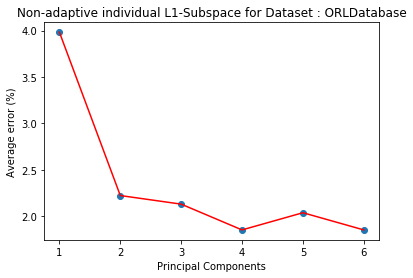

In [184]:
o = {}
for i in range(len(accuracy_list[1])):
    o[i+1] = [0,0]
for i in accuracy_list:
    for j in accuracy_list[i]:
        o[j] = [o[j][0]+accuracy_list[i][j][0],o[j][1]+accuracy_list[i][j][1]]
x = []
y = []
for i in range(1,len(o.keys())+1):
    x.append(i)
    y.append(((o[i][1]-o[i][0])*100)/o[i][1])
plt.plot(x,y,'o')
plt.plot(x,y,'red')
plt.xlabel('Principal Components')
plt.ylabel('Average error (%)')
plt.title('Non-adaptive individual L1-Subspace for Dataset : '+dataset_name)
plt.savefig('Error_rate_graph_for_Dataset_'+dataset_name+'.png')
plt.show()

In [185]:
print(o)

{1: [1037, 1080], 2: [1056, 1080], 3: [1057, 1080], 4: [1060, 1080], 5: [1058, 1080], 6: [1060, 1080]}


# Support Vector Machine

## Data preprocessing

In [186]:
def get_aberdeen_data(directory):
    dataset = []
    label = []
    key = ''
    cnt = 0
    d={}
    for root, dirs, files in os.walk(directory):
        for name in files:
            if re.sub('[^a-zA-Z]','', name.split('.')[0]).strip() not in d:
                d[re.sub('[^a-zA-Z]','', name.split('.')[0]).strip()] = cnt
                cnt += 1
            label.append(d[re.sub('[^a-zA-Z]','', name.split('.')[0]).strip()])
            cap = cv2.imread(directory+'/'+name, cv2.IMREAD_GRAYSCALE)
            cap = cv2.resize(cap, (50, 50))
            dataset.append(cap)
    return dataset,label,d

In [187]:
def get_data_for_models(directory):
    if 'Aberdeen' in directory:
        return get_aberdeen_data(directory)         
    label = []
    dataset = read_dataset(directory,sys.maxsize,sys.maxsize)
    dataset = resize_images(dataset,50,50)
    return dataset, label

# Experimental Studies

## Aberdeen Dataest

In [191]:
number_of_experiment = 5
directory = './Aberdeen_all/'
X,Y,d = get_data_for_models(directory)
X = np.array(X)
z = []
for i in range(len(X)):
    z.append(X[i].flatten())
X = np.array(z[:])
avg_acc = 0
for i in range(number_of_experiment):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.30)
    print('Number of Training Images :',len(y_train),'Number of Testing Images :',len(y_test))
    svclassifier = SVC(kernel='linear')  
    svclassifier.fit(X_train, y_train)
    y_pred = svclassifier.predict(X_test) 
    avg_acc += accuracy_score(y_test, y_pred)
    print('Accuracy',round(accuracy_score(y_test, y_pred)*100,2),'%')
    print(confusion_matrix(y_test,y_pred))  
    print(classification_report(y_test,y_pred)) 
print('Average accuray : ',round(avg_acc/number_of_experiment,2)*100,'%')

Number of Training Images : 480 Number of Testing Images : 207
Accuracy 86.47 %
[[2 0 0 ... 0 0 0]
 [0 2 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 2 0 0]
 [0 0 0 ... 0 4 0]
 [0 0 0 ... 0 0 7]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         9
           5       0.67      1.00      0.80         2
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         1
           8       0.80      1.00      0.89         4
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         0
          12       1.00      1.00      1.00         2
          15       0.62      0.83      0.71         6
          16       1.00      1.00      1.00         1
          21       0.75      1.00      0.86

Accuracy 84.54 %
[[1 0 0 ... 0 0 0]
 [0 3 0 ... 0 0 0]
 [0 0 4 ... 0 0 0]
 ...
 [0 0 0 ... 6 0 0]
 [0 0 0 ... 0 6 0]
 [0 0 0 ... 0 0 6]]
              precision    recall  f1-score   support

           2       0.50      1.00      0.67         1
           3       1.00      1.00      1.00         3
           4       1.00      0.57      0.73         7
           5       0.60      0.75      0.67         4
           8       1.00      1.00      1.00         5
           9       0.50      1.00      0.67         1
          10       0.00      0.00      0.00         1
          12       1.00      0.67      0.80         3
          15       0.80      1.00      0.89         4
          16       1.00      1.00      1.00         1
          21       0.67      1.00      0.80         4
          22       0.00      0.00      0.00         1
          23       1.00      1.00      1.00         1
          24       1.00      1.00      1.00         1
          25       1.00      0.67      0.80         

## Extended Yale B+

In [192]:
number_of_experiment = 5
directory = 'CroppedYale'
X,Y = get_data_for_models(directory)
z = []
l = X.keys()
Y = []
for i in l:
    for j in X[i]:
        z.append(np.array(j).flatten())
        Y.append(i)
X = np.array(z[:])
avg_acc = 0
for i in range(number_of_experiment):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.30)
    print('Number of Training Images :',len(y_train),'Number of Testing Images :',len(y_test))
    svclassifier = SVC(kernel='linear')  
    svclassifier.fit(X_train, y_train)
    y_pred = svclassifier.predict(X_test) 
    avg_acc += accuracy_score(y_test, y_pred)
    print('Accuracy',round(accuracy_score(y_test, y_pred)*100,2),'%')
    print(confusion_matrix(y_test,y_pred))  
    print(classification_report(y_test,y_pred)) 
print('Average accuray : ',round(avg_acc/number_of_experiment,2)*100,'%')


Number of Training Images : 1716 Number of Testing Images : 736
Accuracy 88.59 %
[[20  0  2 ...  0  0  0]
 [ 0 17  1 ...  0  0  0]
 [ 0  0 21 ...  0  0  0]
 ...
 [ 1  0  0 ... 13  0  0]
 [ 0  0  0 ...  0 10  0]
 [ 0  0  0 ...  0  0 15]]
              precision    recall  f1-score   support

     yaleB01       0.83      0.87      0.85        23
     yaleB02       0.81      0.85      0.83        20
     yaleB03       0.84      0.95      0.89        22
     yaleB04       0.91      0.91      0.91        22
     yaleB05       1.00      0.83      0.91        12
     yaleB06       0.80      0.91      0.85        22
     yaleB07       0.83      0.86      0.84        22
     yaleB08       0.84      0.76      0.80        21
     yaleB09       0.94      0.88      0.91        17
     yaleB10       0.63      0.92      0.75        13
     yaleB11       1.00      0.86      0.93        22
     yaleB12       1.00      0.92      0.96        13
     yaleB13       1.00      0.92      0.96        13
     

Accuracy 86.41 %
[[13  0  0 ...  0  0  0]
 [ 0 20  0 ...  0  0  0]
 [ 0  0 18 ...  0  0  0]
 ...
 [ 1  0  1 ... 14  0  0]
 [ 0  0  0 ...  0 13  0]
 [ 1  0  0 ...  0  0 12]]
              precision    recall  f1-score   support

     yaleB01       0.81      0.68      0.74        19
     yaleB02       0.91      1.00      0.95        20
     yaleB03       0.82      0.86      0.84        21
     yaleB04       0.94      0.94      0.94        17
     yaleB05       0.95      0.88      0.91        24
     yaleB06       0.81      0.88      0.84        24
     yaleB07       0.77      0.91      0.83        22
     yaleB08       0.81      0.72      0.76        18
     yaleB09       0.92      0.80      0.86        15
     yaleB10       0.45      0.88      0.60        16
     yaleB11       0.94      0.94      0.94        18
     yaleB12       0.95      1.00      0.98        21
     yaleB13       0.88      0.88      0.88        17
     yaleB15       0.92      0.86      0.89        14
     yaleB16    

## ORL Database

In [193]:
number_of_experiment = 5
directory = 'ORLDatabase'
X,Y = get_data_for_models(directory)
z = []
l = X.keys()
Y = []
for i in l:
    for j in X[i]:
        z.append(np.array(j).flatten())
        Y.append(i)
X = np.array(z[:])
avg_acc = 0
for i in range(number_of_experiment):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.30)
    print('Number of Training Images :',len(y_train),'Number of Testing Images :',len(y_test))
    svclassifier = SVC(kernel='linear')  
    svclassifier.fit(X_train, y_train)
    y_pred = svclassifier.predict(X_test) 
    avg_acc += accuracy_score(y_test, y_pred)
    print('Accuracy',round(accuracy_score(y_test, y_pred)*100,2),'%')
    print(confusion_matrix(y_test,y_pred))  
    print(classification_report(y_test,y_pred)) 
print('Average accuray : ',round(avg_acc/number_of_experiment,2)*100,'%')


Number of Training Images : 280 Number of Testing Images : 120
Accuracy 99.17 %
[[3 0 0 ... 0 0 0]
 [0 1 0 ... 0 1 0]
 [0 0 5 ... 0 0 0]
 ...
 [0 0 0 ... 2 0 0]
 [0 0 0 ... 0 3 0]
 [0 0 0 ... 0 0 3]]
              precision    recall  f1-score   support

          s1       1.00      1.00      1.00         3
         s10       1.00      0.50      0.67         2
         s11       1.00      1.00      1.00         5
         s12       1.00      1.00      1.00         4
         s13       1.00      1.00      1.00         1
         s14       1.00      1.00      1.00         2
         s15       1.00      1.00      1.00         4
         s16       1.00      1.00      1.00         4
         s17       1.00      1.00      1.00         3
         s18       1.00      1.00      1.00         2
         s19       1.00      1.00      1.00         2
          s2       1.00      1.00      1.00         4
         s20       1.00      1.00      1.00         5
         s21       1.00      1.00      1.0

Accuracy 98.33 %
[[3 0 0 ... 0 0 0]
 [0 2 0 ... 0 0 0]
 [0 0 3 ... 0 0 0]
 ...
 [0 0 0 ... 4 0 0]
 [0 0 0 ... 0 4 0]
 [0 0 0 ... 0 0 3]]
              precision    recall  f1-score   support

          s1       1.00      1.00      1.00         3
         s10       1.00      1.00      1.00         2
         s11       0.75      1.00      0.86         3
         s12       1.00      1.00      1.00         1
         s13       1.00      1.00      1.00         4
         s14       1.00      1.00      1.00         4
         s15       1.00      1.00      1.00         3
         s16       1.00      1.00      1.00         1
         s17       1.00      1.00      1.00         3
         s18       1.00      1.00      1.00         4
         s19       1.00      0.67      0.80         3
          s2       1.00      1.00      1.00         3
         s20       1.00      1.00      1.00         3
         s21       1.00      1.00      1.00         5
         s22       1.00      1.00      1.00         

# Exaustive Search

In [194]:
def exaustive_Search(directory):
    number_of_principal_component = 6
    dataset = read_dataset(directory,8,18)
    dataset = resize_images(dataset,50,50)
    number_of_class = len(dataset)
    print(number_of_class)
    number_of_images_per_class = len(dataset[list(dataset)[0]])
    print('Number of Classes :',number_of_class,'\t','Number of Images per Class :',number_of_images_per_class)
    print()
    number_of_train_images_per_class = math.ceil(number_of_images_per_class * 0.7)
    number_of_test_images_per_class = math.floor(number_of_images_per_class * 0.3)
    print('Number of train images per class :',number_of_train_images_per_class,'\t','Number of test images per class :',number_of_test_images_per_class)
    print()
    trainingSet,testingSet = create_test_train_set(dataset,number_of_test_images_per_class,number_of_images_per_class)
    trainingSet,class_mean = mean_subtraction(trainingSet,number_of_train_images_per_class)
    classes = list(trainingSet)
    testingSet = build_testing_set(testingSet)
    dfbopt = pd.DataFrame()
    dfrL1 = pd.DataFrame()
    N = len(trainingSet[list(trainingSet)[0]].T)
    b = list(itertools.product([-1, 1], repeat=N))
    for principal_component_i in range(1,number_of_principal_component+1):
        print('Principal Component :',principal_component_i)
        for class_c in trainingSet:
            max_v = -sys.maxsize
            v = -sys.maxsize
            print('Class :',class_c)
            for i in b:
                dfb = pd.DataFrame(list(i))
                v = LA.norm(trainingSet[class_c].dot(dfb))
                if v > max_v:
                    max_v = v
                    dfbopt[class_c+'_'+str(principal_component_i)] = dfb[list(dfb)[0]].copy()
        for class_c in trainingSet:
            dfrL1[str(principal_component_i)+'_'+class_c] = trainingSet[class_c].dot(dfbopt[class_c+'_'+str(principal_component_i)])/LA.norm(trainingSet[class_c].dot(dfbopt[class_c+'_'+str(principal_component_i)]))
            trainingSet[class_c] = trainingSet[class_c] - dfrL1[[str(principal_component_i)+'_'+class_c]].dot(dfrL1[[str(principal_component_i)+'_'+class_c]].T.dot(trainingSet[class_c]))
    d = NearestNeighbor(testingSet,class_mean,dfrL1,number_of_principal_component,classes)
    return d

# Experiment Studies

## Aberdeen

In [195]:
accuracy_list = {}
dataset_name = 'Aberdeen'
accuracy_list[1] = exaustive_Search(dataset_name)


8
Number of Classes : 8 	 Number of Images per Class : 18

Number of train images per class : 13 	 Number of test images per class : 5

Class : lisa 		 TestSet Index : [10, 5, 4, 6, 17, 1]
Class : louise 		 TestSet Index : [10, 9, 2, 14, 3, 15]
Class : marie 		 TestSet Index : [12, 13, 8, 7, 6, 2]
Class : michael 	 TestSet Index : [15, 1, 10, 14, 3, 9]
Class : nick 		 TestSet Index : [17, 8, 1, 13, 12, 6]
Class : pat 		 TestSet Index : [7, 4, 5, 3, 14, 17]
Class : stephen 	 TestSet Index : [14, 16, 1, 11, 3, 15]
Class : trevor 		 TestSet Index : [10, 2, 13, 17, 6, 3]

Calculating mean for : lisa
Calculating mean for : louise
Calculating mean for : marie
Calculating mean for : michael
Calculating mean for : nick
Calculating mean for : pat
Calculating mean for : stephen
Calculating mean for : trevor

Subtracting mean for : lisa
Subtracting mean for : louise
Subtracting mean for : marie
Subtracting mean for : michael
Subtracting mean for : nick
Subtracting mean for : pat
Subtracting mean

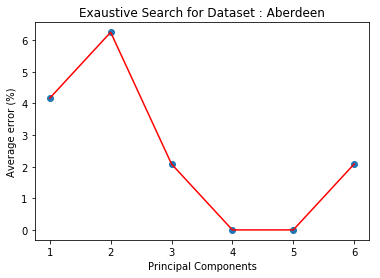

In [196]:
o = {}
for i in range(len(accuracy_list[1])):
    o[i+1] = [0,0]
for i in accuracy_list:
    for j in accuracy_list[i]:
        o[j] = [o[j][0]+accuracy_list[i][j][0],o[j][1]+accuracy_list[i][j][1]]
x = []
y = []
for i in range(1,len(o.keys())+1):
    x.append(i)
    y.append(((o[i][1]-o[i][0])*100)/o[i][1])
plt.plot(x,y,'o')
plt.plot(x,y,'red')
plt.xlabel('Principal Components')
plt.ylabel('Average error (%)')
plt.title('Exaustive Search for Dataset : '+dataset_name)
plt.savefig('Exaustive_Search_for_Dataset_'+dataset_name+'.png')
plt.show()

## Extended Yale Dataset

In [197]:
accuracy_list = {}
dataset_name = 'CroppedYale'
accuracy_list[1] = exaustive_Search(dataset_name)


8
Number of Classes : 8 	 Number of Images per Class : 18

Number of train images per class : 13 	 Number of test images per class : 5

Class : yaleB01 		 TestSet Index : [8, 4, 6, 15, 3, 5]
Class : yaleB02 		 TestSet Index : [16, 6, 11, 12, 2, 10]
Class : yaleB03 		 TestSet Index : [9, 6, 1, 14, 3, 7]
Class : yaleB04 		 TestSet Index : [15, 1, 3, 10, 11, 8]
Class : yaleB05 		 TestSet Index : [7, 8, 15, 5, 13, 10]
Class : yaleB06 		 TestSet Index : [7, 14, 3, 11, 6, 1]
Class : yaleB07 		 TestSet Index : [15, 14, 9, 5, 17, 8]
Class : yaleB08 		 TestSet Index : [2, 17, 10, 7, 14, 8]

Calculating mean for : yaleB01
Calculating mean for : yaleB02
Calculating mean for : yaleB03
Calculating mean for : yaleB04
Calculating mean for : yaleB05
Calculating mean for : yaleB06
Calculating mean for : yaleB07
Calculating mean for : yaleB08

Subtracting mean for : yaleB01
Subtracting mean for : yaleB02
Subtracting mean for : yaleB03
Subtracting mean for : yaleB04
Subtracting mean for : yaleB05
Subtra

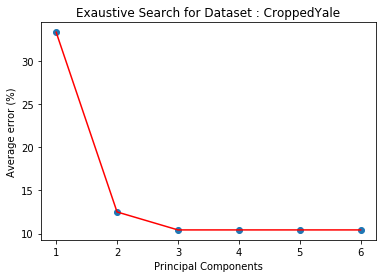

In [198]:
o = {}
for i in range(len(accuracy_list[1])):
    o[i+1] = [0,0]
for i in accuracy_list:
    for j in accuracy_list[i]:
        o[j] = [o[j][0]+accuracy_list[i][j][0],o[j][1]+accuracy_list[i][j][1]]
x = []
y = []
for i in range(1,len(o.keys())+1):
    x.append(i)
    y.append(((o[i][1]-o[i][0])*100)/o[i][1])
plt.plot(x,y,'o')
plt.plot(x,y,'red')
plt.xlabel('Principal Components')
plt.ylabel('Average error (%)')
plt.title('Exaustive Search for Dataset : '+dataset_name)
plt.savefig('Exaustive_Search_for_Dataset_'+dataset_name+'.png')
plt.show()

## ORL Dataset

In [199]:
accuracy_list = {}
dataset_name = 'ORLDatabase'
accuracy_list[1] = exaustive_Search(dataset_name)


8
Number of Classes : 8 	 Number of Images per Class : 10

Number of train images per class : 7 	 Number of test images per class : 3

Class : s1 		 TestSet Index : [1, 8, 3, 4]
Class : s10 		 TestSet Index : [6, 3, 7, 2]
Class : s11 		 TestSet Index : [3, 4, 5, 8]
Class : s12 		 TestSet Index : [8, 7, 9, 6]
Class : s13 		 TestSet Index : [8, 6, 9, 1]
Class : s14 		 TestSet Index : [4, 1, 3, 5]
Class : s15 		 TestSet Index : [5, 1, 8, 4]
Class : s16 		 TestSet Index : [1, 8, 9, 3]

Calculating mean for : s1
Calculating mean for : s10
Calculating mean for : s11
Calculating mean for : s12
Calculating mean for : s13
Calculating mean for : s14
Calculating mean for : s15
Calculating mean for : s16

Subtracting mean for : s1
Subtracting mean for : s10
Subtracting mean for : s11
Subtracting mean for : s12
Subtracting mean for : s13
Subtracting mean for : s14
Subtracting mean for : s15
Subtracting mean for : s16


Principal Component : 1
Class : s1
Class : s10
Class : s11
Class : s12
Class : 

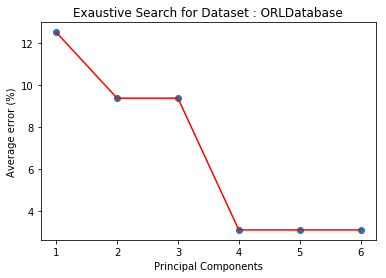

In [200]:
o = {}
for i in range(len(accuracy_list[1])):
    o[i+1] = [0,0]
for i in accuracy_list:
    for j in accuracy_list[i]:
        o[j] = [o[j][0]+accuracy_list[i][j][0],o[j][1]+accuracy_list[i][j][1]]
x = []
y = []
for i in range(1,len(o.keys())+1):
    x.append(i)
    y.append(((o[i][1]-o[i][0])*100)/o[i][1])
plt.plot(x,y,'o')
plt.plot(x,y,'red')
plt.xlabel('Principal Components')
plt.ylabel('Average error (%)')
plt.title('Exaustive Search for Dataset : '+dataset_name)
plt.savefig('Exaustive_Search_for_Dataset_'+dataset_name+'.png')
plt.show()

# Keras CNN

In [205]:
def cnn(dataset,label,d,epochs):
    train_images, test_images, train_labels, test_labels = train_test_split(dataset, label, test_size = 0.30) 
    train_images = np.array(train_images)
    train_labels = np.array(train_labels)
    test_images = np.array(test_images)
    test_labels = np.array(test_labels)
    class_names = {v: k for k, v in d.items()}
    train_images = train_images / 255.0
    test_images = test_images / 255.0
    model = keras.Sequential([
        keras.layers.Flatten(input_shape=(50, 50)),
        keras.layers.Dense(128, activation=tf.nn.relu),
        keras.layers.Dense(102, activation=tf.nn.softmax)
    ])
    model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    model.fit(train_images, train_labels, epochs=epochs)
    test_loss, test_acc = model.evaluate(test_images, test_labels)
    print('Test accuracy:', test_acc*100)

# Experimental Studies

## Aberdeen

In [206]:
directory = 'Aberdeen_all'
dataset,label,d = get_data_for_models(directory)
epochs = 80
cnn(dataset,label,d,epochs)

Epoch 1/80
480/480 [==============================] - 1s 1ms/sample - loss: 4.6727 - acc: 0.0208
Epoch 2/80
480/480 [==============================] - 0s 553us/sample - loss: 4.2657 - acc: 0.0458
Epoch 3/80
480/480 [==============================] - 0s 586us/sample - loss: 4.0750 - acc: 0.0562
Epoch 4/80
480/480 [==============================] - 0s 586us/sample - loss: 3.8856 - acc: 0.1333
Epoch 5/80
480/480 [==============================] - 0s 521us/sample - loss: 3.7242 - acc: 0.1813
Epoch 6/80
480/480 [==============================] - 0s 684us/sample - loss: 3.6131 - acc: 0.1979
Epoch 7/80
480/480 [==============================] - 0s 651us/sample - loss: 3.4992 - acc: 0.2250
Epoch 8/80
480/480 [==============================] - 0s 651us/sample - loss: 3.3859 - acc: 0.2417
Epoch 9/80
480/480 [==============================] - 0s 553us/sample - loss: 3.2558 - acc: 0.2917
Epoch 10/80
480/480 [==============================] - 0s 521us/sample - loss: 3.1254 - acc: 0.3208
Epoch 11/80

## Extended Yale Dataset

In [207]:
directory = 'CroppedYale'
dataset,label = get_data_for_models(directory)
d = list(dataset.keys())
z = []
label = []
dd = {k: v for v, k in enumerate(d)}
for i in d:
    for j in dataset[i]:
        z.append(j)
        label.append(dd[i])
dataset = np.array(z[:])
d = {v: k for k, v in dd.items()}
epochs = 15
cnn(dataset,label,d,epochs)


Epoch 1/15
1716/1716 [==============================] - 2s 910us/sample - loss: 3.7919 - acc: 0.0793
Epoch 2/15
1716/1716 [==============================] - 1s 537us/sample - loss: 2.9165 - acc: 0.2861
Epoch 3/15
1716/1716 [==============================] - 1s 510us/sample - loss: 2.2739 - acc: 0.5017
Epoch 4/15
1716/1716 [==============================] - 1s 546us/sample - loss: 1.7131 - acc: 0.7005
Epoch 5/15
1716/1716 [==============================] - 1s 564us/sample - loss: 1.2934 - acc: 0.8188
Epoch 6/15
1716/1716 [==============================] - 1s 519us/sample - loss: 1.0522 - acc: 0.8537
Epoch 7/15
1716/1716 [==============================] - 1s 528us/sample - loss: 0.8365 - acc: 0.9015
Epoch 8/15
1716/1716 [==============================] - 1s 619us/sample - loss: 0.6830 - acc: 0.9324
Epoch 9/15
1716/1716 [==============================] - 1s 473us/sample - loss: 0.5740 - acc: 0.9406
Epoch 10/15
1716/1716 [==============================] - 1s 483us/sample - loss: 0.4959 - 

## ORL Database

In [208]:
directory = 'ORLDatabase'
dataset,label = get_data_for_models(directory)
d = list(dataset.keys())
z = []
label = []
dd = {k: v for v, k in enumerate(d)}
for i in d:
    for j in dataset[i]:
        z.append(j)
        label.append(dd[i])
dataset = np.array(z[:])
d = {k: v for v, k in enumerate(d)}

d = {v: k for k, v in d.items()}
epochs = 50
cnn(dataset,label,d,epochs)


Epoch 1/50
280/280 [==============================] - 1s 2ms/sample - loss: 4.5783 - acc: 0.0179
Epoch 2/50
280/280 [==============================] - 0s 502us/sample - loss: 4.1421 - acc: 0.0357
Epoch 3/50
280/280 [==============================] - 0s 558us/sample - loss: 3.8222 - acc: 0.0643s - loss: 3.8705 - acc: 0.03
Epoch 4/50
280/280 [==============================] - 0s 558us/sample - loss: 3.6293 - acc: 0.1214
Epoch 5/50
280/280 [==============================] - 0s 614us/sample - loss: 3.4010 - acc: 0.1536
Epoch 6/50
280/280 [==============================] - 0s 558us/sample - loss: 3.1999 - acc: 0.1893
Epoch 7/50
280/280 [==============================] - 0s 558us/sample - loss: 3.0688 - acc: 0.2643
Epoch 8/50
280/280 [==============================] - 0s 558us/sample - loss: 2.8819 - acc: 0.4464
Epoch 9/50
280/280 [==============================] - 0s 614us/sample - loss: 2.7581 - acc: 0.4071
Epoch 10/50
280/280 [==============================] - 0s 558us/sample - loss: 2.6